# Notebook for Cifar-100 using ResNet50
Author: Ambar Roy

# Import Statements

In [1]:
import keras
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from keras.utils import to_categorical

from sklearn.preprocessing import OneHotEncoder
from keras.layers import Input,InputLayer,Activation,Add,AveragePooling2D,Dense,Conv2D,Flatten,MaxPooling2D,Dropout,BatchNormalization,GlobalAveragePooling2D,UpSampling2D,Lambda,ZeroPadding2D

from keras.models import Model,load_model
from keras.datasets import cifar100
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

from keras.applications.resnet50 import ResNet50

# Data Preprocessing

In [2]:
(x_train, y_train), (x_test, y_test)=cifar100.load_data()
print(x_train.shape)
print(y_train.shape)

169001437/169001437 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(50000, 1)


(10000, 32, 32, 3)
(50000, 100)


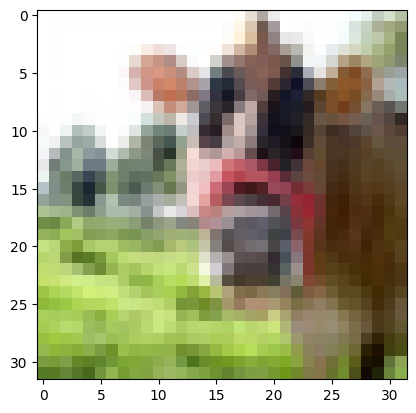

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [4]:
x_train = x_train*1.0/255
x_test = x_test*1.0/255

y_train=to_categorical(y_train, num_classes=100)
y_test=to_categorical(y_test, num_classes=100)

print(x_test.shape)
print(y_train.shape)
plt.imshow(x_train[0])
plt.show()
print(y_train[0])

# Data Augmentation

In [5]:
train_datagen = image.ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    horizontal_flip = True,
    vertical_flip = False
    )
train_datagen.fit(x_train)

# Adjusting Learning Rate
Used to solve exploding gradient problem

In [6]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.6,
    min_lr=1e-6)

# Building Model

In [10]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [11]:
# Author Ambar Roy

cnn=keras.models.Sequential(name='ResNet50-for-Cifar100')

# cnn.add(myresnet)
cnn.add(UpSampling2D(size=(7, 7),interpolation='bilinear'))
cnn.add(resnet)
cnn.add(GlobalAveragePooling2D(name='GAvgP'))
cnn.add(Dropout(0.25,name='Drop1'))
cnn.add(Dense(256, activation='relu', name='Dense'))
cnn.add(BatchNormalization(name='BN'))
cnn.add(Dense(100, activation='softmax', name='OL'))
cnn.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),loss='categorical_crossentropy',metrics=['accuracy'])
# checkpoint = ModelCheckpoint('best_weights.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
cnn.build(input_shape=(None, 224, 224, 3))
cnn.summary()

Model: "ResNet50-for-Cifar100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2  (None, 1568, 1568, 3)     0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 GAvgP (GlobalAveragePoolin  (None, 2048)              0         
 g2D)                                                            
                                                                 
 Drop1 (Dropout)             (None, 2048)              0         
                                                                 
 Dense (Dense)               (None, 256)               524544    
                                                                 
 BN (BatchNormalization)     (None, 256)     

# Training Model

In [13]:
mymodel=cnn.fit(x_train, y_train, validation_split=0.2, epochs = 35, verbose = 1, callbacks = [learning_rate_reduction])

Epoch 1/35
1250/1250 [==============================] - 355s 264ms/step - loss: 2.9572 - accuracy: 0.2981 - val_loss: 1.9411 - val_accuracy: 0.4982 - lr: 0.0010
Epoch 2/35
1250/1250 [==============================] - 329s 263ms/step - loss: 1.7530 - accuracy: 0.5346 - val_loss: 1.4117 - val_accuracy: 0.6078 - lr: 0.0010
Epoch 3/35
1250/1250 [==============================] - 329s 263ms/step - loss: 1.4176 - accuracy: 0.6074 - val_loss: 1.2448 - val_accuracy: 0.6439 - lr: 0.0010
Epoch 4/35
1250/1250 [==============================] - 317s 254ms/step - loss: 1.2464 - accuracy: 0.6475 - val_loss: 1.1495 - val_accuracy: 0.6670 - lr: 0.0010
Epoch 5/35
1250/1250 [==============================] - 329s 263ms/step - loss: 1.1326 - accuracy: 0.6750 - val_loss: 1.0870 - val_accuracy: 0.6827 - lr: 0.0010
Epoch 6/35
1250/1250 [==============================] - 329s 263ms/step - loss: 1.0472 - accuracy: 0.6992 - val_loss: 1.0363 - val_accuracy: 0.6958 - lr: 0.0010
Epoch 7/35
1250/1250 [============

# Plotting Graphs

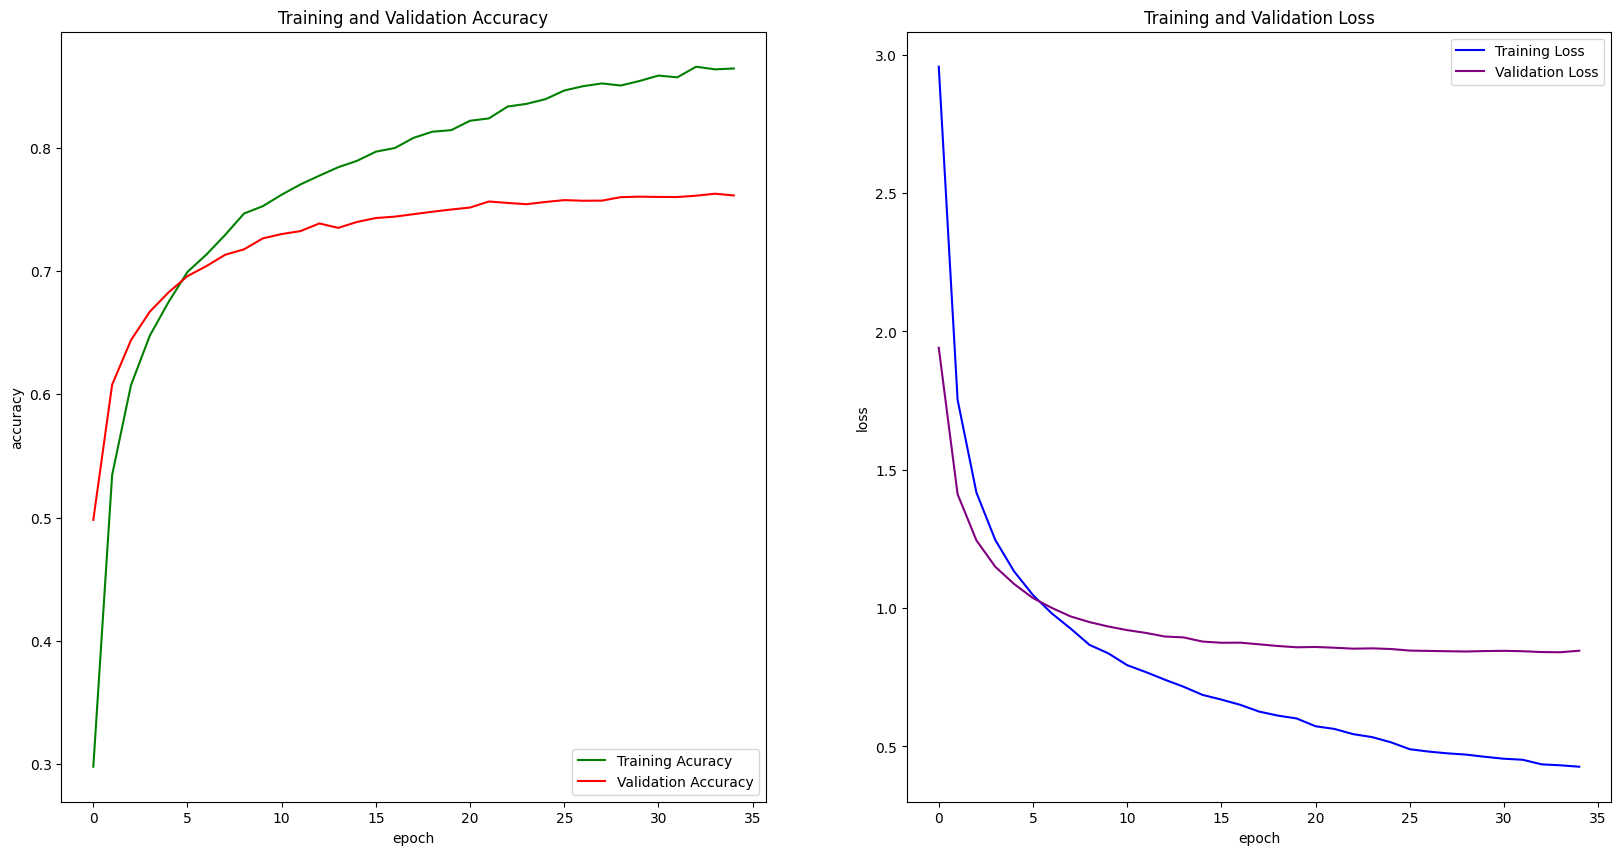

In [17]:
acc = mymodel.history['accuracy']
val_acc = mymodel.history['val_accuracy']
loss = mymodel.history['loss']
val_loss = mymodel.history['val_loss']

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title("Training and Validation Accuracy")
plt.plot(acc,color = 'green',label = 'Training Acuracy')
plt.plot(val_acc,color = 'red',label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.title('Training and Validation Loss')
plt.plot(loss,color = 'blue',label = 'Training Loss')
plt.plot(val_loss,color = 'purple',label = 'Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')

plt.show()

# Testing Model

In [15]:
cnn.evaluate(x_test,y_test)

313/313 [==============================] - 30s 96ms/step - loss: 0.8065 - accuracy: 0.7683


[0.8065193295478821, 0.7682999968528748]